In [13]:
import numpy as np
from numpy import random
import pandas as pd
from sklearn import neighbors
import matplotlib.pyplot as plt
%matplotlib inline

# Get the original data


In [2]:
train_all = pd.read_csv('../Data_case1/mitbih_train.csv', delimiter = ',', header=None)
test = pd.read_csv('../Data_case1/mitbih_train.csv', delimiter = ',', header=None)

In [3]:
set(train_all[187].values)

{0.0, 1.0, 2.0, 3.0, 4.0}

In [4]:
train_all0 = train_all[train_all[187]==0]
train_all1 = train_all[train_all[187]==1]
train_all2 = train_all[train_all[187]==2]
train_all3 = train_all[train_all[187]==3]
train_all4 = train_all[train_all[187]==4]

In [5]:
print('Number of data points in each class:')
print('Class 0: ', len(train_all0))
print('Class 1: ', len(train_all1))
print('Class 2: ', len(train_all2))
print('Class 3: ', len(train_all3))
print('Class 4: ', len(train_all4))

Number of data points in each class:
Class 0:  72471
Class 1:  2223
Class 2:  5788
Class 3:  641
Class 4:  6431


### The plan is to undersample class 0 and oversample classes 1 and 3.
We want to try out 4 methods for the oversampling:
    - basically oversampling by duplicate the data
    - add a bit of white noise to the signals
    - move the signals in the time space
    - use SMOTE

#### Undersample class 0

In [94]:
def undersample(ratio, input_data):
    # input_data has to be train_allX for X = 0, 1, 2, 3, 4
    class_array = np.array(input_data)
    N = int(ratio*len(class_array))
    random.shuffle(class_array)
    output = class_array[:N,:]
    return output

In [96]:
len(undersample(0.5, train_all0))

36235

#### Duplicate the data

In [92]:
def generate_duplicates(ratio, input_data):
    # input_data has to be train_allX for X = 0, 1, 2, 3, 4
    old_length = len(input_data)
    N = int(ratio*old_length)
    class_array = np.array(input_data)
    output = None
    for i in range(N):
        n = random.randint(old_length)
        if output is not None:
            output = np.vstack([output, class_array[n,:]])
        else:
            output = class_array[n,:] 
    return output

In [93]:
class1 = generate_duplicates(1, train_all1)
class1.shape

(2223, 188)

In [34]:
all_classes = np.vstack([class0, class1, class2, class3, class4])
all_classes.shape

(68219, 188)

In [36]:
np.savetxt('../Data_case1/binary_duplicate_under.csv', all_classes, delimiter=',')

#### Add some white noise
A small white noise will be added to a random choice of vectors, only on strictly positive values.

In [44]:
random.randint(-10,10)

3

#### Move the signals in the time space (add a delay)


In [52]:
NEW_LENGTH_OF_CLASS1 = 4000
old_length = len(train_all1)
diff = NEW_LENGTH_OF_CLASS1 - old_length
class1_delay = np.array(train_all1)
vector_len = len(class1_delay[0,:])
for i in range(diff):
    n = random.randint(old_length)
    delay = random.randint(-10,10)
    if delay >= 0:
        v = np.array([0] * delay)
        new_obs = np.hstack([ v.reshape(1,delay) + class1_delay[n,:vector_len-delay].reshape(1,vector_len-delay)])
    else:
        delay = -delay
        v = np.array([0] * delay)
        new_obs = np.hstack([class1_delay[n,delay:].reshape(1,vector_len-delay) + v.reshape(1,delay)])
    class1_delay = np.vstack([class1_delay, new_obs])

ValueError: operands could not be broadcast together with shapes (1,9) (1,179) 

#### SMOTE

In [88]:
def generate_SMOTE(ratio, input_data):
    # input_data has to be train_allX for X = 0, 1, 2, 3, 4
    class_array = np.array(input_data)
    old_length = len(input_data)
    N = int(ratio*old_length) # Number of new elements to create
    NNmodel = neighbors.NearestNeighbors(n_neighbors=5)
    NNmodel.fit(class_array[:,:-1])
    class_id = int(class_array[0][-1])
    output = None
    for i in range(N):
        k = random.randint(old_length)
        origin_point = class_array[k,:-1]
        neigh = NNmodel.kneighbors([origin_point], return_distance=False)
        indx = random.randint(5)
        chosen_neighbor = neigh[0][indx]
        r = random.rand()
        new_point = origin_point + r*(chosen_neighbor - origin_point)
        new_point = np.hstack([new_point, [class_id]])
        if output is not None:
            output = np.vstack([output, new_point])
        else:
            output = new_point    
    return output

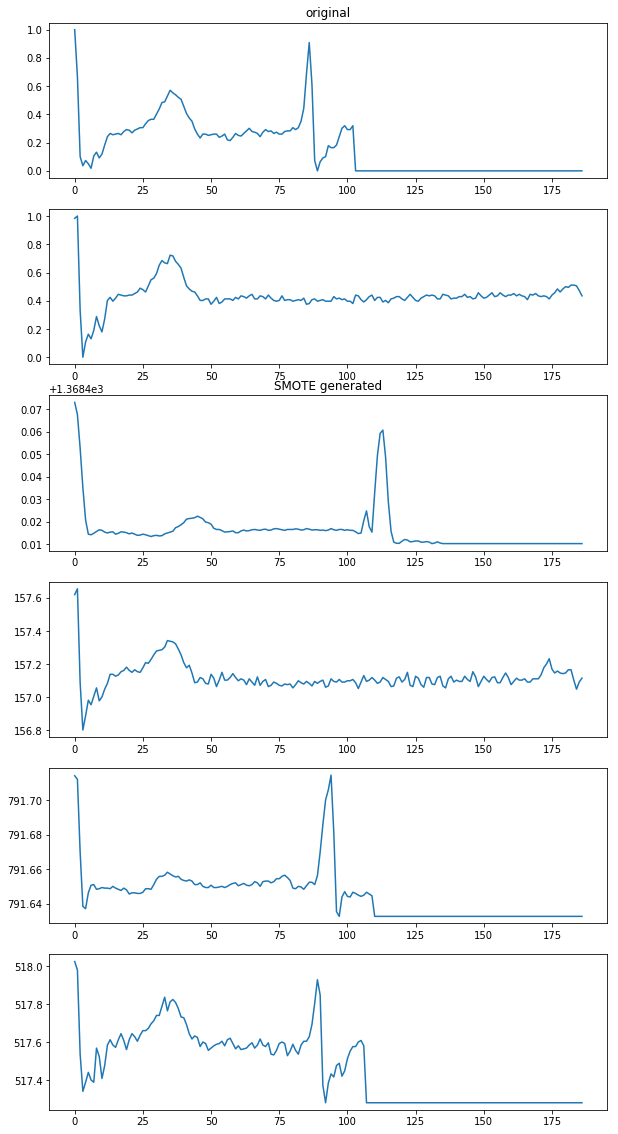

In [87]:
plt.rcParams['figure.figsize'] = [10, 20]
fig, ax = plt.subplots(6,1)
ax[0].plot(class1[0][:-1])
ax[0].set_title('original')
ax[1].plot(class1[1][:-1])
ax[2].set_title('SMOTE generated')
ax[2].plot(class1[2301][:-1])
ax[3].plot(class1[2302][:-1])
ax[4].plot(class1[2303][:-1])
ax[5].plot(class1[2304][:-1])

### New dataset generation

In [102]:
class0 = undersample(0.05, train_all0)
class1 = np.vstack([np.array(train_all1), generate_SMOTE(1, train_all1)])
class2 = np.array(train_all2)
class3 = np.vstack([np.array(train_all3), generate_SMOTE(2, train_all3)])
class4 = np.array(train_all4)
all_classes = np.vstack([class0, class1, class2, class3, class4])
np.savetxt('Data_case1/5class_SMOTE_undersampling3.csv', all_classes, delimiter=',')